In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from scipy.signal import lfilter
import solverFunctions as sf
import analysisFunctions as af
from scipy.interpolate import LinearNDInterpolator

In [3]:
def GetFlow(order_bc,continuous=False):
    if continuous:
        con_str = "C"
    else:
        con_str = "DC"
    u = np.load(r"DataDC/dataset"+con_str+"_u_30_1_"+str(order_bc)+".npy")
    v = np.load(r"DataDC/dataset"+con_str+"_v_30_1_"+str(order_bc)+".npy")
    p = np.load(r"DataDC/dataset"+con_str+"_p_30_1_"+str(order_bc)+".npy")
    return u,v,p

# data = list(zip(GetFlow(1),GetFlow(2),GetFlow(3),GetFlow(5),GetFlow(4,True)))
data = list(zip(GetFlow(1),GetFlow(2)))
# data = list(zip(GetFlow(4,True)))
u = np.concatenate(data[0],axis=0)
v = np.concatenate(data[1],axis=0)
p = np.concatenate(data[2],axis=0)
p = p-np.expand_dims(p.mean((1,2)),axis=(1,2))

def GetBoundary(u,v):
    u_n = (u[:,:,1:]+u[:,:,:-1])/2
    v_n = (v[:,1:,:]+v[:,:-1,:])/2
    u_bc = np.concatenate([u_n[:,1:-1,0],u_n[:,-1,1:-1],u_n[:,1:-1,-1][:,::-1],u_n[:,0,1:-1][:,::-1]],axis=1)
    v_bc = np.concatenate([v_n[:,1:-1,0],v_n[:,-1,1:-1],v_n[:,1:-1,-1][:,::-1],v_n[:,0,1:-1][:,::-1]],axis=1)
    return u_bc,v_bc

u_bc,v_bc = GetBoundary(u,v)

p.shape

(15176, 30, 30)

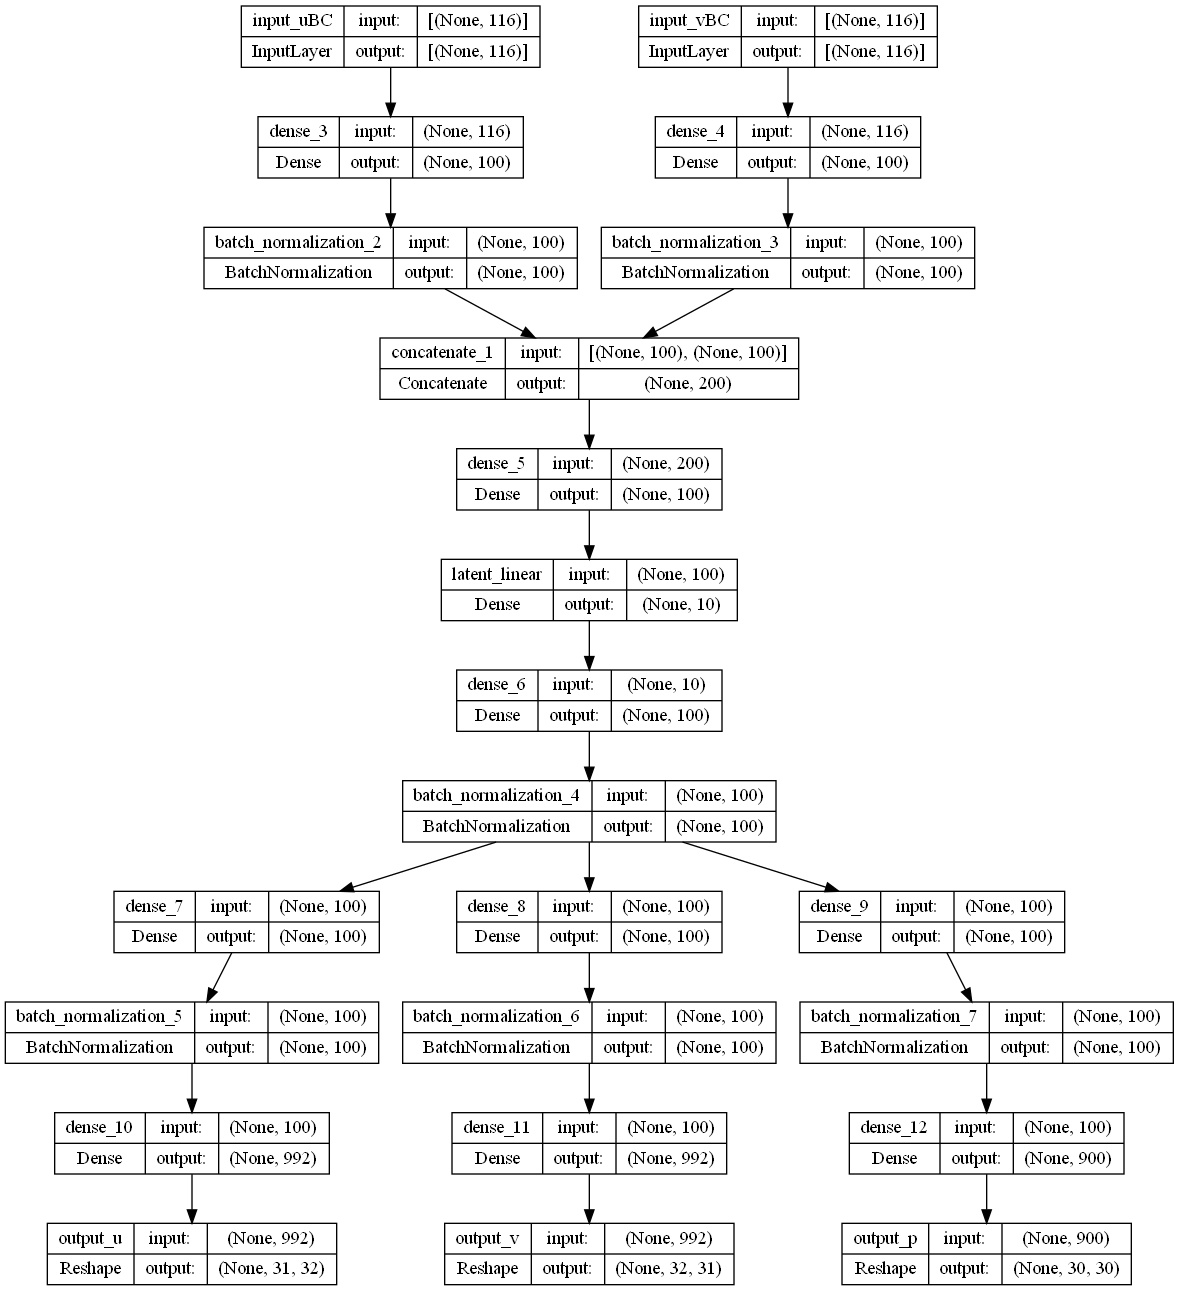

In [5]:
def GetEncoderStaggered(n_latent,input_shapes):
    input_u = Input(shape=input_shapes[0], name='input_uBC')
    input_v = Input(shape=input_shapes[1], name='input_vBC')
    x_u = Flatten()(input_u)
    x_v = Flatten()(input_v)
    x = Concatenate()([x_u,x_v])
    latent = Dense(n_latent)(x)
    encoder = Model([input_u,input_v],latent,name="encoder")
    return encoder,input_u,input_v,latent

def GetDecoderStaggered(n_latent,output_shapes,latent):
    # input_latent = Input(shape=(n_latent,))
    input_latent = latent
    output_u = Dense(np.prod(output_shapes[0]),use_bias=False)(input_latent)
    output_u = Reshape(output_shapes[0],name="output_u")(output_u)
    output_v = Dense(np.prod(output_shapes[1]),use_bias=False)(input_latent)
    output_v = Reshape(output_shapes[1],name="output_v")(output_v)
    output_p = Dense(np.prod(output_shapes[2]),use_bias=False)(input_latent)
    output_p = Reshape(output_shapes[2],name="output_p")(output_p)
    decoder = Model(input_latent,[output_u,output_v,output_p],name="decoder")
    return decoder,input_latent,output_u,output_v,output_p

def GetAEStaggered(input_shapes,output_shapes,n_latent):
    encoder,input_u,input_v,latent = GetEncoderStaggered(n_latent,input_shapes)
    decoder,input_latent,output_u,output_v,output_p = GetDecoderStaggered(n_latent,output_shapes,latent)
    model = Model([input_u,input_v], [output_u,output_v,output_p],name="model_staggered")
    
    return model, encoder, decoder

def GetEncoderStaggeredNL(n_latent,input_shapes,nodes):
    input_u = Input(shape=input_shapes[0], name='input_uBC')
    input_v = Input(shape=input_shapes[1], name='input_vBC')
    x_u,x_v = input_u,input_v

    for i in range(len(nodes[0])):
        x_u = Dense(nodes[0][i],activation='sigmoid')(x_u)
        x_u = BatchNormalization()(x_u)

        x_v = Dense(nodes[0][i],activation='sigmoid')(x_v)
        x_v = BatchNormalization()(x_v)
    
    x = Concatenate()([x_u,x_v])
    for i in range(len(nodes[1])):
        x = Dense(nodes[1][i],activation='sigmoid')(x)
        if (i < len(nodes[1])-1):
            x = BatchNormalization()(x)

    latent = Dense(n_latent,name='latent_linear')(x)
    encoder = Model([input_u,input_v],latent,name="encoder")
    return encoder,input_u,input_v,latent

def GetDecoderStaggeredNL(n_latent,output_shapes,latent,nodes):

    x = latent
    for i in range(len(nodes[1])-1,-1,-1):
        x = Dense(nodes[1][i],activation='sigmoid')(x)
        x = BatchNormalization()(x)

    x_u,x_v,x_p = x,x,x
    for i in range(len(nodes[0])-1,-1,-1):
        x_u = Dense(nodes[0][i],activation='sigmoid')(x_u)
        x_u = BatchNormalization()(x_u)

        x_v = Dense(nodes[0][i],activation='sigmoid')(x_v)
        x_v = BatchNormalization()(x_v)

        x_p = Dense(nodes[0][i],activation='sigmoid')(x_p)
        x_p = BatchNormalization()(x_p)
    
    output_u = Dense(np.prod(output_shapes[0]))(x_u)
    output_u = Reshape(output_shapes[0],name="output_u")(output_u)

    output_v = Dense(np.prod(output_shapes[1]))(x_v)
    output_v = Reshape(output_shapes[1],name="output_v")(output_v)

    output_p = Dense(np.prod(output_shapes[2]))(x_p)
    output_p = Reshape(output_shapes[2],name="output_p")(output_p)

    decoder = Model(latent,[output_u,output_v,output_p],name="decoder")
    return decoder,x,output_u,output_v,output_p

def GetAEStaggeredNL(input_shapes,output_shapes,n_latent,nodes=[[100,100],[100,100]]):
    encoder,input_u,input_v,latent = GetEncoderStaggeredNL(n_latent,input_shapes,nodes)
    decoder,input_latent,output_u,output_v,output_p = GetDecoderStaggeredNL(n_latent,output_shapes,latent,nodes)
    model = Model([input_u,input_v], [output_u,output_v,output_p],name="model_staggered")
    
    return model, encoder, decoder

n_latent = 10
input_shapes = (u_bc[0].shape,v_bc[0].shape)
output_shapes = (u[0].shape,v[0].shape,p[0].shape)
modelL, encoderL, decoderL = GetAEStaggeredNL(input_shapes,output_shapes,n_latent,nodes=[[100],[100]])
tf.keras.utils.plot_model(modelL, show_shapes=True)

In [101]:
def con_res_loss(u,v,prob):
    mp_e = prob.rho*prob.dy_p*u[:,1:,1:-1]
    mp_w = prob.rho*prob.dy_p*u[:,:-1,1:-1]
    mp_n = prob.rho*prob.dx_p*v[:,1:-1,1:]
    mp_s = prob.rho*prob.dx_p*v[:,1:-1,:-1]
    dmp = mp_w+mp_s-mp_e-mp_n
    con_res = tf.reduce_sum(tf.square(dmp),axis=(1,2))
    return con_res

def u_res_loss(u,v,p,prob):
    mu_e = prob.rho*prob.dy_u*(u[:,1:-1,1:-1]+u[:,2:,1:-1])/2
    mu_w = prob.rho*prob.dy_u*(u[:,:-2,1:-1]+u[:,1:-1,1:-1])/2
    mu_n = prob.rho*prob.dx_u*(v[:,1:-2,1:]+v[:,2:-1,1:])/2
    mu_s = prob.rho*prob.dx_u*(v[:,1:-2,:-1]+v[:,2:-1,:-1])/2
    convection = -(mu_e*(u[:,2:,1:-1]+u[:,1:-1,1:-1])/2\
    + mu_n*(u[:,1:-1,2:]+u[:,1:-1,1:-1])/2\
    - mu_w*(u[:,:-2,1:-1]+u[:,1:-1,1:-1])/2\
    - mu_s*(u[:,1:-1,:-2]+u[:,1:-1,1:-1])/2)
    diffusion = prob.Aud_x[:-1,:]*(u[:,1:-1,1:-1]-u[:,:-2,1:-1]) + prob.Aud_x[1:,:]*(u[:,1:-1,1:-1]-u[:,2:,1:-1]) +\
        prob.Aud_y[:,:-1]*(u[:,1:-1,1:-1]-u[:,1:-1,:-2]) + prob.Aud_y[:,1:]*(u[:,1:-1,1:-1]-u[:,1:-1,2:])
    pressure = prob.dy_u*(p[:,1:,:]-p[:,:-1,:])
    u_res = tf.reduce_sum(tf.square(convection-diffusion-pressure),axis=(1,2))
    return u_res

def v_res_loss(u,v,p,prob):
    mv_e = prob.rho*prob.dy_v*(u[:,1:,1:-2]+u[:,1:,2:-1])/2
    mv_w = prob.rho*prob.dy_v*(u[:,:-1,1:-2]+u[:,:-1,2:-1])/2
    mv_n = prob.rho*prob.dx_v*(v[:,1:-1,1:-1]+v[:,1:-1,2:])/2
    mv_s = prob.rho*prob.dx_v*(v[:,1:-1,1:-1]+v[:,1:-1,:-2])/2
    convection = -(mv_e*(v[:,2:,1:-1]+v[:,1:-1,1:-1])/2\
    + mv_n*(v[:,1:-1,2:]+v[:,1:-1,1:-1])/2\
    - mv_w*(v[:,:-2,1:-1]+v[:,1:-1,1:-1])/2\
    - mv_s*(v[:,1:-1,:-2]+v[:,1:-1,1:-1])/2)
    diffusion = prob.Avd_x[:-1,:]*(v[:,1:-1,1:-1]-v[:,:-2,1:-1]) + prob.Avd_x[1:,:]*(v[:,1:-1,1:-1]-v[:,2:,1:-1]) +\
        prob.Avd_y[:,:-1]*(v[:,1:-1,1:-1]-v[:,1:-1,:-2]) + prob.Avd_y[:,1:]*(v[:,1:-1,1:-1]-v[:,1:-1,2:])
    pressure = prob.dx_v*(p[:,:,1:]-p[:,:,:-1])
    # v_res_CV = (convection-diffusion-pressure)*(prob.dx_v*prob.dy_v)
    # v_res = tf.reduce_mean(tf.square(v_res_CV),axis=(1,2))
    v_res = tf.reduce_sum(tf.square(convection-diffusion-pressure),axis=(1,2))
    return v_res

def r_lossF(x,x_r,prob):
    reconstruction_u_loss = tf.reduce_sum(tf.square((x[0][:,1:-1,1:-1]-x_r[0][:,1:-1,1:-1])*(prob.dx_u*prob.dy_u)), axis=(1,2))
    reconstruction_v_loss = tf.reduce_sum(tf.square((x[1][:,1:-1,1:-1]-x_r[1][:,1:-1,1:-1])*(prob.dx_v*prob.dy_v)), axis=(1,2))
    reconstruction_p_loss = tf.reduce_sum(tf.square((x[2]-x_r[2])*(prob.dx_p*prob.dy_p)), axis=(1,2))
    return reconstruction_u_loss,reconstruction_v_loss,reconstruction_p_loss

def ae_loss_function(x,x_r,r_weights,fd_weight,prob):
    reconstruction_u_loss,reconstruction_v_loss,reconstruction_p_loss = r_lossF(x,x_r,prob)
    reconstruction_loss = r_weights[0] * reconstruction_u_loss\
        + r_weights[1] * reconstruction_v_loss\
        + r_weights[2] * reconstruction_p_loss
    finite_difference_loss = tf.math.log(con_res_loss(x_r[0],x_r[1],prob)) + tf.math.log(u_res_loss(x_r[0],x_r[1],x_r[2],prob)) + tf.math.log(v_res_loss(x_r[0],x_r[1],x_r[2],prob))
    loss = reconstruction_loss + fd_weight*finite_difference_loss
    return loss, reconstruction_loss, reconstruction_u_loss, reconstruction_v_loss, reconstruction_p_loss, finite_difference_loss

@tf.function
# def train_step_VAE(x,r_weights,fd_weight,prob):
def train_step_VAE(model,optimizer,x_bc,x,r_weights,fd_weight,prob):
    with tf.GradientTape() as tape:
        
        x_r = model(x_bc,training=True)

        loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = ae_loss_function(x,x_r, r_weights, fd_weight,prob)

    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    return loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss

class History():
    def __init__(self,n):
        self.loss = np.zeros(n)
        self.r_loss = np.zeros(n)
        self.r_u_loss = np.zeros(n)
        self.r_v_loss = np.zeros(n)
        self.r_p_loss = np.zeros(n)
        self.l_loss = np.zeros(n)
        self.fd_loss = np.zeros(n)
        
    def add(self,history):
        self.loss = np.concatenate([self.loss,history.loss],axis=0)
        self.r_loss = np.concatenate([self.r_loss,history.r_loss],axis=0)
        self.r_u_loss = np.concatenate([self.r_u_loss,history.r_u_loss],axis=0)
        self.r_v_loss = np.concatenate([self.r_v_loss,history.r_v_loss],axis=0)
        self.r_p_loss = np.concatenate([self.r_p_loss,history.r_p_loss],axis=0)
        self.l_loss = np.concatenate([self.l_loss,history.l_loss],axis=0)
        self.fd_loss = np.concatenate([self.fd_loss,history.fd_loss],axis=0)

def train_VAE(model,optimizer,x_bc,x,n_epochs,n_batch,prob,r_weights=0.005,fd_weight=1,modelPath=None):
    n_steps = n_epochs#*len(range(0,x[0].shape[0],n_batch))
    history = History(n_steps)
    index = 0
    loss_min = np.inf
    x_bc[0] = tf.cast(x_bc[0],tf.float32)
    x_bc[1] = tf.cast(x_bc[1],tf.float32)

    x[0] = tf.cast(x[0],tf.float32)
    x[1] = tf.cast(x[1],tf.float32)
    x[2] = tf.cast(x[2],tf.float32)
    r_weights = tf.cast(r_weights,tf.float32)
    loss_epoch = np.zeros((x[0].shape[0]))
    r_loss_epoch = np.zeros((x[0].shape[0]))
    ru_loss_epoch = np.zeros((x[0].shape[0]))
    rv_loss_epoch = np.zeros((x[0].shape[0]))
    rp_loss_epoch = np.zeros((x[0].shape[0]))
    fd_loss_epoch = np.zeros((x[0].shape[0]))
    
    for epoch in range(n_epochs):
        indices = tf.range(start=0, limit=tf.shape(x[0])[0], dtype=tf.int32)
        idx = tf.random.shuffle(indices)
        x_bc[0] = tf.gather(x_bc[0],idx)
        x_bc[1] = tf.gather(x_bc[1],idx)

        x[0] = tf.gather(x[0],idx)
        x[1] = tf.gather(x[1],idx)
        x[2] = tf.gather(x[2],idx)


        for batch in range(0,x[0].shape[0],n_batch):
            x_bc_batch = [x_bc[0][batch:batch+n_batch],x_bc[1][batch:batch+n_batch]]
            x_batch = [x[0][batch:batch+n_batch],x[1][batch:batch+n_batch],x[2][batch:batch+n_batch]]
            loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = train_step_VAE(model,optimizer,x_bc_batch,x_batch,r_weights,fd_weight,prob)
            # loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = train_step_VAE(x_batch,r_weights,fd_weight,prob)
            loss_epoch[batch:batch+loss.shape[0]] = loss
            r_loss_epoch[batch:batch+loss.shape[0]] = r_loss
            ru_loss_epoch[batch:batch+loss.shape[0]] = r_u_loss
            rv_loss_epoch[batch:batch+loss.shape[0]] = r_v_loss
            rp_loss_epoch[batch:batch+loss.shape[0]] = r_p_loss
            fd_loss_epoch[batch:batch+loss.shape[0]] = fd_loss

            
            print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}\t".format(epoch+1,n_epochs, 100*batch/x[0].shape[0],loss_epoch.mean()),end="") #
        
        history.loss[index] = loss_epoch.mean()
        history.r_loss[index] = r_loss_epoch.mean()
        history.r_u_loss[index] = ru_loss_epoch.mean()
        history.r_v_loss[index] = rv_loss_epoch.mean()
        history.r_p_loss[index] = rp_loss_epoch.mean()
        history.fd_loss[index] = fd_loss_epoch.mean()
        index+=1
            
        # print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100,loss_epoch.mean()),end="\n")
        if (modelPath!=None) and (loss_epoch.mean()<loss_min):
            try:
                loss_min = loss_epoch.mean()
                model.save_weights(modelPath)
                print("\nmodel saved; loss = {}".format(loss_min))
            except:
                print("\nunable to save")
            
    return history
 
 
class LossCFD(tf.keras.losses.Loss):
  def __init__(self,r_weights,fd_weight,prob):
    super().__init__()
    self.r_weights = r_weights
    self.fd_weight = fd_weight
    self.prob = prob
  def call(self, x,x_pred):
    loss,_,_,_,_,_ = ae_loss_function(x,x_pred,self.r_weights,self.fd_weight,self.prob)
    return loss

In [51]:
n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
modelPathL = "MLmodels/ModelsBC/NS_BC10D__"
fd_weight = 0.00003
n_epochs = 50
n_batch = 128
x_bc = [u_bc,v_bc]
x = [u,v,p]
input_shapes = (u_bc[0].shape,v_bc[0].shape)
output_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)

modelL, encoderL, decoderL = GetAEStaggered(input_shapes,output_shapes,n_latent)
modelL.load_weights(modelPathL)
optimizer = tf.keras.optimizers.Adam(0.0002)
historyL = train_VAE(modelL,optimizer,x_bc,x,n_epochs,n_batch,prob,r_weights,fd_weight,modelPathL)
# history.add(history_add)

1/50 epochs - 99.5%; loss = 0.00030321		
model saved; loss = 0.0003032149104390116
2/50 epochs - 99.5%; loss = 0.00026696		
model saved; loss = 0.0002669635531533955
3/50 epochs - 99.5%; loss = 0.00026474	
model saved; loss = 0.00026474236705844646
5/50 epochs - 99.5%; loss = 0.00026301		
model saved; loss = 0.0002630093496202281
6/50 epochs - 99.5%; loss = 0.00026291		
model saved; loss = 0.00026290696018337284
7/50 epochs - 99.5%; loss = 0.0002611			
model saved; loss = 0.0002610969145253882
11/50 epochs - 99.5%; loss = 0.00026001		
model saved; loss = 0.00026000663276426575
28/50 epochs - 99.5%; loss = 0.00025931		
model saved; loss = 0.0002593135441849563
42/50 epochs - 99.5%; loss = 0.00025931		
model saved; loss = 0.00025930816151052477
46/50 epochs - 99.5%; loss = 0.00025849		
model saved; loss = 0.0002584912185544913
50/50 epochs - 99.5%; loss = 0.00025922		

In [102]:
n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
modelPath = "MLmodels/ModelsBC/NS_BC10D_200_200200" #"MLmodels/NS_10D_300_200200200"
fd_weight = 0.00003
n_epochs = 5000
n_batch = 128
x_bc = [u_bc,v_bc]
x = [u,v,p]
input_shapes = (u_bc[0].shape,v_bc[0].shape)
output_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)

model, encoder, decoder = GetAEStaggeredNL(input_shapes,output_shapes,n_latent,nodes=[[200],[200,200]])
model.load_weights(modelPath)
optimizer = tf.keras.optimizers.Adam(0.001)
history = train_VAE(model,optimizer,x_bc,x,n_epochs,n_batch,prob,r_weights,fd_weight,modelPath=modelPath)
# history.add(history_add)

1/5000 epochs - 99.5%; loss = -0.00031115		
model saved; loss = -0.00031115159035106205
2/5000 epochs - 99.5%; loss = -0.00039399		
model saved; loss = -0.0003939887779826368
3/5000 epochs - 99.5%; loss = -0.00039861		
model saved; loss = -0.0003986054171060784
4/5000 epochs - 99.5%; loss = -0.00040984		
model saved; loss = -0.00040984381505455994
5/5000 epochs - 99.5%; loss = -0.00041165		
model saved; loss = -0.00041165261636461905
6/5000 epochs - 99.5%; loss = -0.00042158		
model saved; loss = -0.0004215750843831156
7/5000 epochs - 99.5%; loss = -0.0004305			
model saved; loss = -0.00043050481004079064
8/5000 epochs - 99.5%; loss = -0.00043235		
model saved; loss = -0.0004323532969838787
9/5000 epochs - 99.5%; loss = -0.00043401		
model saved; loss = -0.0004340059418968219
10/5000 epochs - 99.5%; loss = -0.00044042	
model saved; loss = -0.0004404223358938441
12/5000 epochs - 99.5%; loss = -0.00045748		
model saved; loss = -0.00045748396259505787
13/5000 epochs - 99.5%; loss = -0.000

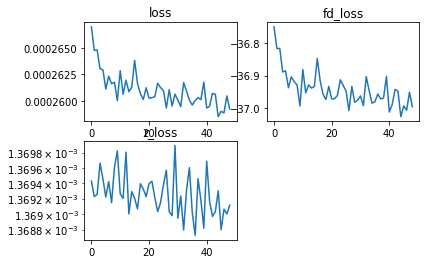

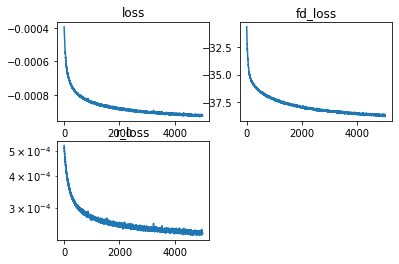

In [103]:

def plotHist(history,i_start = 0):
    plt.subplot(2,2,1)
    plt.plot(history.loss[i_start:])
    plt.title("loss")
    plt.subplot(2,2,2)
    plt.plot(history.fd_loss[i_start:])
    plt.title("fd_loss")
    plt.subplot(2,2,3)
    plt.plot(history.r_loss[i_start:])
    plt.title("r_loss")
    plt.gca().set_yscale('log')
    plt.show()

plotHist(historyL,1)
plotHist(history,1)

In [105]:
def ae_loss_function(x,x_r,r_weights,fd_weight,prob):
    reconstruction_u_loss,reconstruction_v_loss,reconstruction_p_loss = r_lossF(x,x_r,prob)
    reconstruction_loss = r_weights[0] * reconstruction_u_loss\
        + r_weights[1] * reconstruction_v_loss\
        + r_weights[2] * reconstruction_p_loss
    finite_difference_loss = tf.math.log(con_res_loss(x_r[0],x_r[1],prob)) + tf.math.log(u_res_loss(x_r[0],x_r[1],x_r[2],prob)) + tf.math.log(v_res_loss(x_r[0],x_r[1],x_r[2],prob))
    loss = reconstruction_loss + fd_weight*finite_difference_loss
    return loss, reconstruction_loss, reconstruction_u_loss, reconstruction_v_loss, reconstruction_p_loss, finite_difference_loss


def Evaluate(model,u_bc,v_bc,u,v,p,prob,reduce=True):
    u_r,v_r,p_r = model([u_bc,v_bc])
    # mse_u,mse_v,mse_p = tf.reduce_mean(tf.square(u-u_r),axis=(0,1,2)),tf.reduce_mean(tf.square(v-v_r),axis=(0,1,2)),tf.reduce_mean(tf.square(p-p_r),axis=(0,1,2))
    mse_u,mse_v,mse_p = r_lossF([u,v,p],[u_r,v_r,p_r],prob)
    mse_u,mse_v,mse_p = tf.sqrt(mse_u),tf.sqrt(mse_v),tf.sqrt(mse_p)
    u_res,v_res,con_res = u_res_loss(u_r,v_r,p_r,prob),v_res_loss(u_r,v_r,p_r,prob),con_res_loss(u_r,v_r,prob)
    if reduce:
        mse_u,mse_v,mse_p = tf.reduce_mean(mse_u),tf.reduce_mean(mse_v),tf.reduce_mean(mse_p)
        u_res,v_res,con_res = tf.reduce_mean(u_res),tf.reduce_mean(v_res),tf.reduce_mean(con_res)
    return mse_u.numpy(),mse_v.numpy(),mse_p.numpy(),u_res.numpy(),v_res.numpy(),con_res.numpy()

def ModelLoss(model,u_bc,v_bc,u,v,p,prob,r_weights,fd_weight,reduce=True):
    u_r,v_r,p_r = model([u_bc,v_bc])
    loss, r_loss,ru,rv,rp,fd_loss = ae_loss_function([u,v,p],[u_r,v_r,p_r],r_weights,fd_weight,prob)
    if reduce:
        return loss.numpy().mean(),r_loss.numpy().mean(),fd_loss.numpy().mean()
    return loss.numpy(),r_loss.numpy(),fd_loss.numpy()

# r_weights = [1/u.var(),1/v.var(),1/p.var()]
# fd_weight = 0.00003

mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate(model,u_bc,v_bc,u,v,p,prob,True)
print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate(modelL,u_bc,v_bc,u,v,p,prob,True)
print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
# mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate(modelL,u_bc,v_bc,u,v,p,prob,True)
# print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
loss,r_loss,fd_loss = ModelLoss(model,u_bc,v_bc,u,v,p,prob,r_weights,fd_weight,reduce=True)
print(loss,r_loss,fd_loss)
loss,r_loss,fd_loss = ModelLoss(modelL,u_bc,v_bc,u,v,p,prob,r_weights,fd_weight,reduce=True)
print(loss,r_loss,fd_loss)

0.0036677457 0.0035398991 0.0025931296 0.0016011297 0.0010975722 1.3125954e-06
0.0064981207 0.0065895715 0.0076022316 0.0003912549 0.00038861512 1.3670153e-07
-0.0008999443 0.0002573308 -38.57584
0.00027543266 0.0013687286 -36.4432


[0.16805121 0.2125565  0.09367085 0.19930418 0.20670848 0.2752281
 0.18834497 0.13575277 0.16784804 0.19299053]
1.8404556289315224
[-0.18979236 -0.2508306  -0.6906402  -0.23376529 -1.2147363  -1.398689
  3.5642798   0.42383194 -0.09771856 -1.4388969 ]


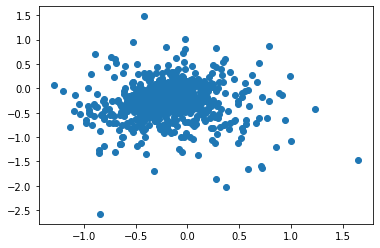

In [64]:
l_points = encoder([u_bc,v_bc]).numpy()
print(l_points.var(0))
print(sum(l_points.var(0)))
print(l_points.mean(0))
plt.scatter(l_points[:1000,0],l_points[:1000,1])

100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


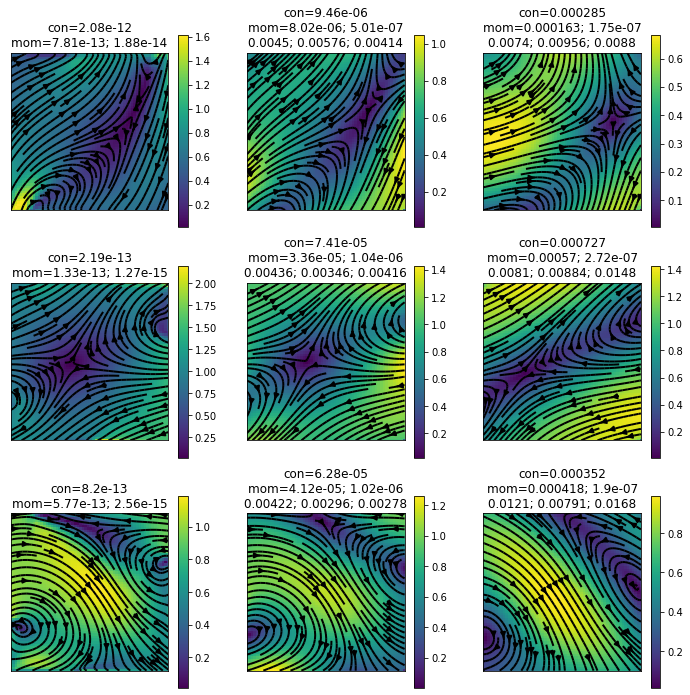

In [108]:
def PlotFlow(u,v,prob,ax):
    X_n,Y_n = np.meshgrid(prob.xc_u,prob.yc_v)
    u_n = (u[:,:-1]+u[:,1:])/2
    v_n = (v[:-1,:]+v[1:,:])/2
    u_n = np.transpose(u_n)
    v_n = np.transpose(v_n)
    X,Y = np.meshgrid(np.linspace(0,1,u_n.shape[0]*2),np.linspace(0,1,u_n.shape[1]*2))
    points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
    values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
    interp = LinearNDInterpolator(points_n, values_n)
    values_i = interp(X,Y)
    u_c = values_i[:,:,0]
    v_c = values_i[:,:,1]
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    c = ax.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
    plt.colorbar(c)
    ax.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)


def Compare(n,model1,model2,u_bc,v_bc,u,v,p,prob):
    n = min(n,u.shape[0])
    u_r1,v_r1,p_r1 = model1([u_bc[:n],v_bc[:n]])
    u_r1,v_r1,p_r1 = u_r1.numpy(),v_r1.numpy(),p_r1.numpy()
    u_r2,v_r2,p_r2 = model2([u_bc[:n],v_bc[:n]])
    u_r2,v_r2,p_r2 = u_r2.numpy(),v_r2.numpy(),p_r2.numpy()

    # mse_u1,mse_v1,mse_p1 = np.square(u[:n]-u_r1).mean((1,2)),np.square(v[:n]-v_r1).mean((1,2)),np.square(p[:n]-p_r1).mean((1,2))
    # mse_u2,mse_v2,mse_p2 = np.square(u[:n]-u_r2).mean((1,2)),np.square(v[:n]-v_r2).mean((1,2)),np.square(p[:n]-p_r2).mean((1,2))
    mse_u1,mse_v1,mse_p1 = r_lossF([u[:n],v[:n],p[:n]],[u_r1,v_r1,p_r1],prob)
    mse_u2,mse_v2,mse_p2 = r_lossF([u[:n],v[:n],p[:n]],[u_r2,v_r2,p_r2],prob)
    plt.figure(figsize=(12,4*n))
    for i in tqdm(range(n)):
        ax = plt.subplot(n,3,3*i+1)
        PlotFlow(u[i],v[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}".format(float(u_res_loss(u[i:i+1],v[i:i+1],p[i:i+1],prob)),float(v_res_loss(u[i:i+1],v[i:i+1],p[i:i+1],prob)),float(con_res_loss(u[i:i+1],v[i:i+1],prob))))
        ax = plt.subplot(n,3,3*i+2)
        PlotFlow(u_r1[i],v_r1[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}\n{:.3g}; {:.3g}; {:.3g}".format(float(u_res_loss(u_r1[i:i+1],v_r1[i:i+1],p_r1[i:i+1],prob)),float(v_res_loss(u_r1[i:i+1],v_r1[i:i+1],p_r1[i:i+1],prob)),float(con_res_loss(u_r1[i:i+1],v_r1[i:i+1],prob)),np.sqrt(mse_u1[i]),np.sqrt(mse_v1[i]),np.sqrt(mse_p1[i])))
        ax = plt.subplot(n,3,3*i+3)
        PlotFlow(u_r2[i],v_r2[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}\n{:.3g}; {:.3g}; {:.3g}".format(float(u_res_loss(u_r2[i:i+1],v_r2[i:i+1],p_r2[i:i+1],prob)),float(v_res_loss(u_r2[i:i+1],v_r2[i:i+1],p_r2[i:i+1],prob)),float(con_res_loss(u_r2[i:i+1],v_r2[i:i+1],prob)),np.sqrt(mse_u2[i]),np.sqrt(mse_v2[i]),np.sqrt(mse_p2[i])))
    plt.show()

i = 10010
Compare(3,model,modelL,u_bc[i:],v_bc[i:],u[i:],v[i:],p[i:],prob)

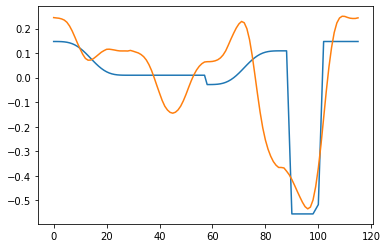

In [137]:
from turtle import color

n = 10000
u_r,v_r,p_r = model([u_bc[:],v_bc[:]])
u_r_bc,v_r_bc = GetBoundary(u_r,v_r)
plt.plot(np.transpose(u_bc[n-1:n]))
plt.plot(np.transpose(u_r_bc[n-1:n]))

In [118]:
colorArr

array([0.        , 0.33333333, 0.66666667])